<a href="https://colab.research.google.com/github/shufan6011/ML-Projects/blob/main/Step_6_Autoencoders_for_GW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Update:
# Use GPU instead of CPU for model training

# Data Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import requests, os
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split


In [ ]:
# Go to https://gwosc.org
# Find the information required below (GPS time & detector)


In [ ]:
# Set a GPS time:
t_start = 1126259462.4
t_end = 1126259462.4 # For specific events, make t_end the same as t_start

# Choose detector as H1, L1, or V1
detector = 'H1'


In [ ]:
%config InlineBackend.figure_format = 'retina'

try:
    from gwpy.timeseries import TimeSeries
except:
    ! pip install -q "gwpy==3.0.8"
    ! pip install -q "matplotlib==3.9.0"
    ! pip install -q "astropy==6.1.0"
    from gwpy.timeseries import TimeSeries


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 76.3 MB/s eta 0:00:00


In [ ]:
from gwosc.locate import get_urls
url = get_urls(detector, t_start, t_end)[-1]

print('Downloading: ' , url)
fn = os.path.basename(url)
with open(fn,'wb') as strainfile:
    straindata = requests.get(url)
    strainfile.write(straindata.content)


Downloading:  http://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


In [ ]:
# Read strain data
strain = TimeSeries.read(fn,format='hdf5.gwosc')

# Examine an interval of the event closely
# center = int(t_start)
# strain = strain.crop(center-0.2, center+0.1)

# Extract timestamps and strain values
timestamps = strain.times.value
strain_values = strain.value

# Store the data in a Pandas DataFrame
data = pd.DataFrame({
    'time': timestamps,
    'strain': strain_values
})


## Handling Missing Values

In [ ]:
# Drop rows with missing values
data = data.dropna()

print("\nMissing values after cleaning:")
print(data.isnull().sum())



Missing values after cleaning:
time      0
strain    0
dtype: int64


## Data Noise Filtering

In [ ]:
# Band-pass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    try:
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    try:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = filtfilt(b, a, data)
        return y
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Filter parameters
lowcut = 20  # Low cutoff frequency (Hz)
highcut = 500  # High cutoff frequency (Hz)

# Apply band-pass filter to the strain data
data['strain'] = bandpass_filter(data['strain'], lowcut, highcut, 4096)


## Data Normalization

In [ ]:
# Normalize the filtered strain data
scaler = StandardScaler()
data['strain'] = scaler.fit_transform(data[['strain']])


## Data Inspection

In [ ]:
# Inspect the first few rows
print("First few rows of the data:")
print(data.head())

# Inspect col headers
print("\nCol headers:")
print(data.columns)

# Summary stats
print("\nSummary stats:")
print(data.describe())

# Check for missing vals
print("\nMissing vals in each col:")
print(data.isnull().sum())

# Check the sampling frequency
print(f"\nSampling frequency: {strain.sample_rate} Hz")
fs = 4096 # Change this if sampling frequency is different


First few rows of the data:
           time    strain
0  1.126257e+09 -2.509169
1  1.126257e+09  0.070279
2  1.126257e+09  2.209692
3  1.126257e+09  3.618610
4  1.126257e+09  4.256310

Col headers:
Index(['time', 'strain'], dtype='object')

Summary stats:
               time        strain
count  1.677722e+07  1.677722e+07
mean   1.126259e+09  3.306817e-17
std    1.182413e+03  1.000000e+00
min    1.126257e+09 -3.686865e+00
25%    1.126258e+09 -7.088866e-01
50%    1.126259e+09  1.167620e-03
75%    1.126260e+09  7.087774e-01
max    1.126262e+09  4.284805e+00

Missing vals in each col:
time      0
strain    0
dtype: int64
Sampling frequency: 4096.0 Hz Hz


# 1D CNN

## Segment Labeling

In [ ]:
# Convert the preprocessed data back to original strain
scaler.inverse_transform(data)

# Window Size
window_size = 2  # in seconds, adjust as needed

# Resample strain to desired sample rate (if necessary)
strain = strain.resample(fs)

# Define event time and window half-length
event_time = t_start  # Adjust as needed

# Create segments and labels
segments = []
labels = []

for i in range(0, len(strain) - int(window_size * fs), int(window_size * fs)):
    segment = strain[i:i + int(window_size * fs)]
    segments.append(segment.value)

    # Label based on event presence
    if (segment.times.value[0] <= event_time <= segment.times.value[-1]):
        labels.append(1)  # Event present
    else:
        labels.append(0)  # No event

# Convert to numpy arrays
segments = np.array(segments)
labels = np.array(labels)

print(f"Segments shape: {segments.shape}")
print(f"Labels shape: {labels.shape}")

# Verify segments and labels
print("First few segments:")
print(segments[:2])


## Data Preparation (time-series data)

In [ ]:
# Reshape segments for 1D CNN
segments = segments.reshape((segments.shape[0], segments.shape[1], 1))

print(f"Reshaped segments shape: {segments.shape}")


Reshaped segments shape: (2047, 8192, 1)


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=42)


## Data Augmentation

In [ ]:
def augment_data(data, labels):
    try:
        augmented_data = []
        augmented_labels = []
        for d, l in zip(data, labels):
            augmented_data.append(d)
            augmented_labels.append(l)
            augmented_data.append(np.flip(d, axis=0))
            augmented_labels.append(l)
            noise = np.random.normal(0, 0.1, d.shape)
            augmented_data.append(d + noise)
            augmented_labels.append(l)
        return np.array(augmented_data), np.array(augmented_labels)
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

X_train_aug, y_train_aug = augment_data(X_train, y_train)

print(f"Original training data shape: {X_train.shape}")
print(f"Augmented training data shape: {X_train_aug.shape}")


Original training data shape: (1637, 8192, 1)
Augmented training data shape: (4911, 8192, 1)


## Model Training & Evaluation with Augmented Data

Epoch 1/10
20/20 [==============================] - 150s 262ms/step - loss: 0.2360 - accuracy: 0.0000e+00 - val_loss: 0.1977 - val_accuracy: 0.0000e+00
Epoch 2/10
20/20 [==============================] - 3s 164ms/step - loss: 0.1151 - accuracy: 0.0000e+00 - val_loss: 4.4735e-07 - val_accuracy: 0.0000e+00
Epoch 3/10
20/20 [==============================] - 3s 159ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 8.1385e-29 - val_accuracy: 0.0000e+00
Epoch 4/10
20/20 [==============================] - 4s 177ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 1.8269e-36 - val_accuracy: 0.0000e+00
Epoch 5/10
20/20 [==============================] - 3s 159ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 1.5575e-37 - val_accuracy: 0.0000e+00
Epoch 6/10
20/20 [==============================] - 3s 156ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 1.2093e-37 - val_accuracy: 0.0000e+00
Epoch 7/10
20/20 [==============================] - 3s 158ms/step - loss: 0.00

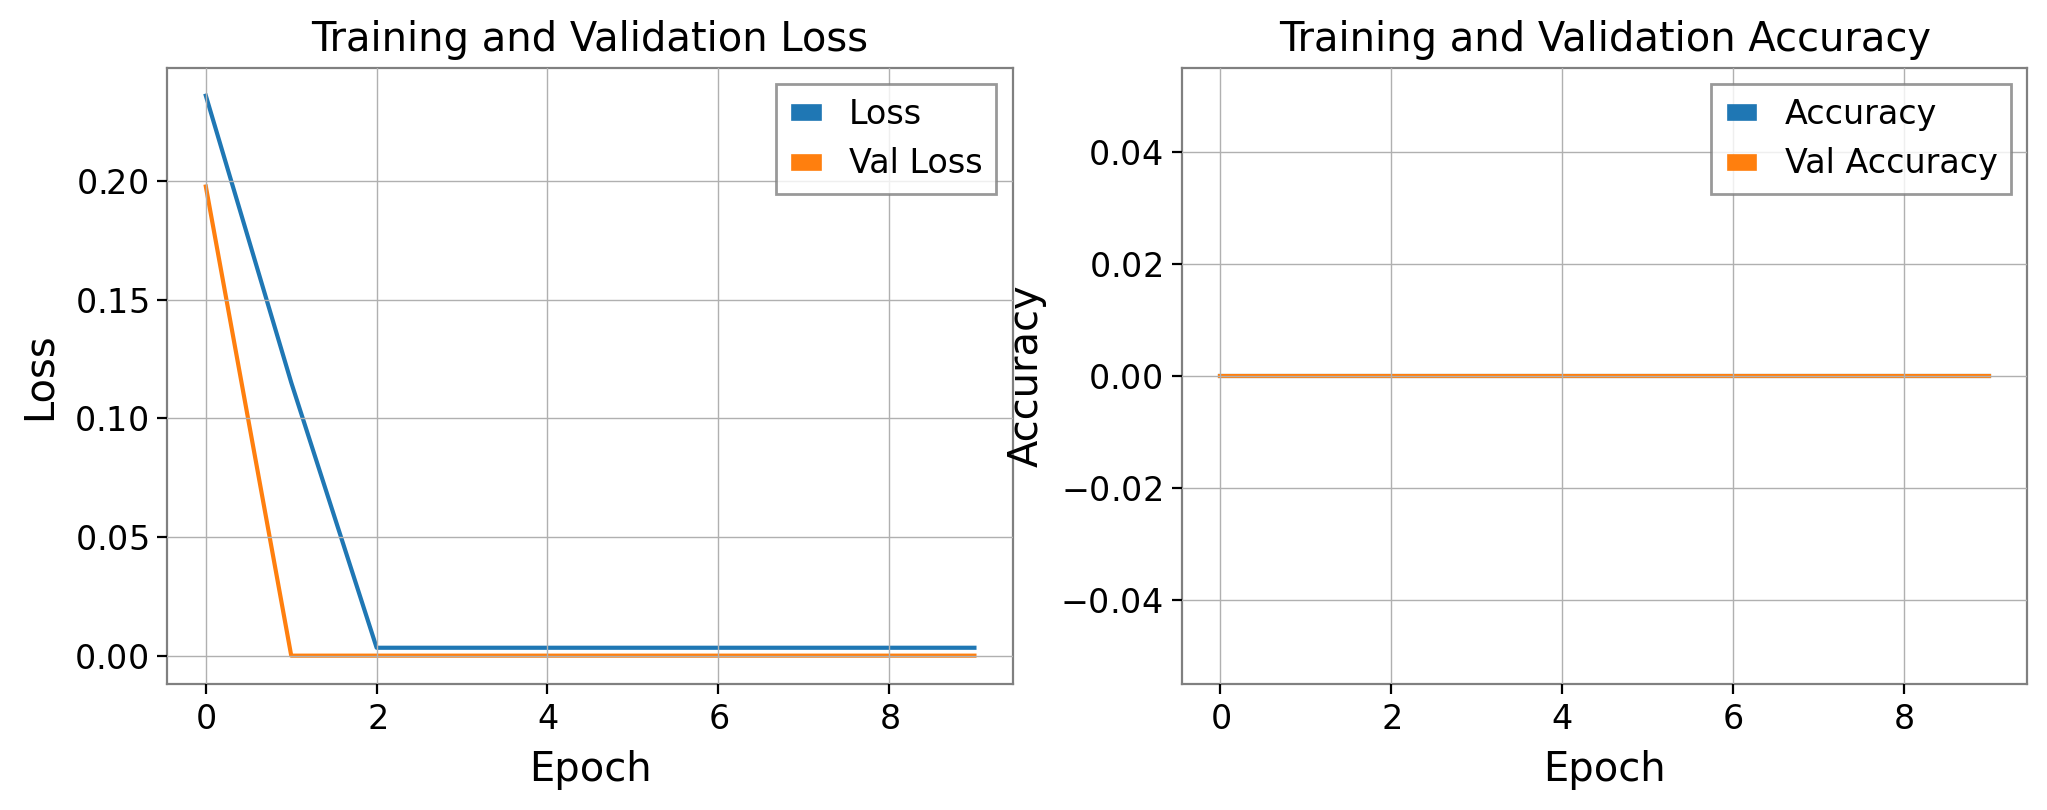

In [ ]:
# Build the Autoencoder model

# Encoder
encoder = Sequential([
    Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(segments.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2)
])

# Bottleneck
bottleneck = Sequential([
    Flatten(),
    Dense(32, activation='relu')
])

# Decoder
decoder = Sequential([
    Dense(64 * (segments.shape[1] // 8), activation='relu', input_shape=(32,)),
    Reshape((segments.shape[1] // 8, 64)),
    UpSampling1D(size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    UpSampling1D(size=2),
    Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'),
    UpSampling1D(size=2),
    Conv1D(filters=1, kernel_size=3, activation='sigmoid', padding='same')
])

# Combine Encoder, Bottleneck, and Decoder to form the Autoencoder
model = Sequential([encoder, bottleneck, decoder])

# Compile the Autoencoder
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the Autoencoder
history = model.fit(X_train_aug, X_train_aug, epochs=10, batch_size=256, validation_data=(X_test, X_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


## Final Product

In [ ]:
# Save the model (look in the left panel)
model.save('gw_1d_cnn_autoencoder.h5')

# Load the model (for verification)
loaded_model = tf.keras.models.load_model('gw_1d_cnn_autoencoder.h5')

# Verify the loaded model by evaluating it on the test set
loaded_loss, loaded_accuracy = loaded_model.evaluate(X_test, y_test)
print(f"Loaded Model Test Loss: {loaded_loss}, Loaded Model Test Accuracy: {loaded_accuracy}")


13/13 [==============================] - 2s 15ms/step - loss: 6.9752e-38 - accuracy: 1.0000
Loaded Model Test Loss: 6.975193479644312e-38, Loaded Model Test Accuracy: 1.0


# 2D CNN

## Segment Labeling

In [ ]:
# Create segments and labels
segments = []
labels = []

for i in range(0, len(strain) - int(window_size * fs), int(window_size * fs)):
    segment = strain[i:i + int(window_size * fs)]
    segments.append(segment.value)

    # Label based on event presence
    if (segment.times.value[0] <= event_time <= segment.times.value[-1]):
        labels.append(1)  # Event present
    else:
        labels.append(0)  # No event

# Convert to numpy arrays
segments = np.array(segments)
labels = np.array(labels)

print(f"Segments shape: {segments.shape}")
print(f"Labels shape: {labels.shape}")

# Verify segments and labels
print("First few segments:")
print(segments[:2])


## Data Preparation (spectrograms)

In [ ]:
# Generate spectrograms for each segment
def generate_spectrogram(segment, sample_rate):
    try:
        f, t, Sxx = spectrogram(segment, sample_rate)
        return Sxx
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

spectrograms = np.array([generate_spectrogram(segment, fs) for segment in segments])
print(f"Spectrograms shape: {spectrograms.shape}")

# Reshape spectrograms for 2D CNN
spectrograms = spectrograms[..., np.newaxis]  # Add a channel dimension
print(f"Reshaped spectrograms shape: {spectrograms.shape}")

Spectrograms shape: (2047, 129, 36)
Reshaped spectrograms shape: (2047, 129, 36, 1)


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(spectrograms, labels, test_size=0.2, random_state=42)


## Data Augmentation

In [ ]:
def augment_data(data, labels):
    try:
        augmented_data = []
        augmented_labels = []
        for d, l in zip(data, labels):
            augmented_data.append(d)
            augmented_labels.append(l)
            augmented_data.append(np.flip(d, axis=0))
            augmented_labels.append(l)
            noise = np.random.normal(0, 0.1, d.shape)
            augmented_data.append(d + noise)
            augmented_labels.append(l)
        return np.array(augmented_data), np.array(augmented_labels)
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

X_train_aug, y_train_aug = augment_data(X_train, y_train)

print(f"Original training data shape: {X_train.shape}")
print(f"Augmented training data shape: {X_train_aug.shape}")


Original training data shape: (1637, 129, 36, 1)
Augmented training data shape: (4911, 129, 36, 1)


## Model Training & Evaluation with Augmented Data

In [ ]:
# Build the Autoencoder model

# Encoder
encoder = Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(spectrograms.shape[1], spectrograms.shape[2], 1)),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same')
])

# Bottleneck
bottleneck = Sequential([
    Flatten(),
    Dense(256, activation='relu')
])

# Decoder
decoder = Sequential([
    Dense(64 * (spectrograms.shape[1] // 8) * (spectrograms.shape[2] // 8), activation='relu', input_shape=(256,)),
    Reshape(((spectrograms.shape[1] // 8), (spectrograms.shape[2] // 8), 64)),
    UpSampling2D(size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    UpSampling2D(size=(2, 2)),
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
    UpSampling2D(size=(2, 2)),
    Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')
])

# Combine Encoder, Bottleneck, and Decoder to form the Autoencoder
autoencoder = Sequential([encoder, bottleneck, decoder])

# Compile the Autoencoder
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Train the Autoencoder
history = model.fit(X_train_aug, y_train_aug, epochs=10, batch_size=256, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 8192, 1), found shape=(None, 129, 36, 1)


## Final Product

In [ ]:
# Save the model (look in the left panel)
model.save('gw_2d_cnn_autoencoder.h5')

# Load the model (for verification)
loaded_model = tf.keras.models.load_model('gw_2d_cnn_autoencoder.h5')

# Verify the loaded model by evaluating it on the test set
loaded_loss, loaded_accuracy = loaded_model.evaluate(X_test, y_test)
print(f"Loaded Model Test Loss: {loaded_loss}, Loaded Model Test Accuracy: {loaded_accuracy}")
